In [55]:
import yfinance as yf
import pandas as pd
import backtrader as bt
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from ta.trend import EMAIndicator

plt.rcParams["figure.figsize"] = [16,9]

# ml training



In [56]:
data = yf.download("ETH-USD",interval="15m",start="2021-03-01",end="2021-04-14")

[*********************100%***********************]  1 of 1 completed


In [57]:
# get optimal sell values
def runOnce(data,emaFast,emaMiddle):
    
    data["EMA25"] = EMAIndicator(data["Close"],window=emaFast).ema_indicator()
    data["EMA50"] = EMAIndicator(data["Close"],window=emaMiddle).ema_indicator()

    startMoney = 40000
    money = startMoney
    nrStocks = 0
    portfolio = []
    wins = []

    waitForEntry = False

    stopLoss = 0
    takeProfit = 0
    boughtAt = 0

    def buy(crntPrice, money, data, nrStocks, stopLoss, takeProfit, boughtAt):
        # and today crossed EMA25 take buy position
        # stopLoss = EMA50, takeProfit = 1.5 * EMA50
        boughtAt = crntPrice
        howmany = int(money / crntPrice)
        cost = howmany * crntPrice 
        if (cost*1.00075) > money:
            cost = (howmany-1) * crntPrice 
        money -= (cost*1.00075) # commsision!
        nrStocks += howmany
        stopLoss = data["EMA50"][i]
        takeProfit = data["EMA50"][i] * 1.5
        print(i,"Long Buying %d positions at %.2f$, SL: %.2f$, TP: %.2f$"%(howmany,crntPrice,stopLoss,takeProfit))
        return crntPrice, money, data, nrStocks, stopLoss, takeProfit, boughtAt

    def sell(crntPrice, money, data, nrStocks, stopLoss, takeProfit, boughtAt):
        # sell
        value = crntPrice * nrStocks
        money += (value*(1-.00075)) # commission!
        win = value - (nrStocks * boughtAt)
        nrStocks = 0
        # just for safety
        boughtAt = 0
        stopLoss = 0
        takeProfit = 0
        return crntPrice, money, data, nrStocks, stopLoss, takeProfit, boughtAt, win


    for i,crntPrice in enumerate(data["Close"]):
        crntPrice = data["Close"][i]
        if i > 0:
            if nrStocks == 0:
                # if no positions yet
                if data["EMA25"][i] > data["EMA50"][i]:
                    crntPrice, money, data, nrStocks, stopLoss, takeProfit, boughtAt = buy(crntPrice, money, data, nrStocks, stopLoss, takeProfit, boughtAt)

            ## If we have positions just listen to exit 
            elif nrStocks > 0: # if we have long positions
                if data["EMA25"][i] < data["EMA50"][i]: 
                    crntPrice, money, data, nrStocks, stopLoss, takeProfit, boughtAt, win = sell(crntPrice, money, data, nrStocks, stopLoss, takeProfit, boughtAt)
                    print(i,"Long Sell EMAcross, Loss: %.2f$, crntHolding: %.2f$"%(win,money))
                    wins.append(win)
            elif nrStocks < 0: # if we have short positions
                pass

        # keep track of portfolio value
        portValue = money + (nrStocks * crntPrice)
        portfolio.append(portValue)
    return portfolio,wins

portfolio,wins = runOnce(data.copy(),20,110)

109 Long Buying 25 positions at 1564.89$, SL: 1511.50$, TP: 2267.25$
171 Long Sell EMAcross, Loss: -1433.86$, crntHolding: 38508.53$
215 Long Buying 24 positions at 1544.20$, SL: 1520.97$, TP: 2281.45$
311 Long Sell EMAcross, Loss: -123.39$, crntHolding: 38329.64$
358 Long Buying 24 positions at 1587.83$, SL: 1572.26$, TP: 2358.39$
364 Long Sell EMAcross, Loss: -943.37$, crntHolding: 37329.82$
466 Long Buying 24 positions at 1527.84$, SL: 1504.79$, TP: 2257.18$
883 Long Sell EMAcross, Loss: 5864.69$, crntHolding: 43135.10$
906 Long Buying 23 positions at 1834.23$, SL: 1813.13$, TP: 2719.69$
955 Long Sell EMAcross, Loss: -426.29$, crntHolding: 42645.85$
958 Long Buying 23 positions at 1830.28$, SL: 1823.65$, TP: 2735.48$
961 Long Sell EMAcross, Loss: -378.09$, crntHolding: 42204.90$
1038 Long Buying 23 positions at 1812.72$, SL: 1795.97$, TP: 2693.95$
1091 Long Sell EMAcross, Loss: -423.24$, crntHolding: 41719.44$
1189 Long Buying 23 positions at 1783.41$, SL: 1771.00$, TP: 2656.51$
131

# first backtest for optimal parameters

In [58]:
# startWindow = 190
# stopWindow = 440

# buyline = 198
# sellline = 400

# plt.axvline(x=data.index[buyline],label="buy",color="g")
# plt.axvline(x=data.index[sellline],label="sell",color="r")

# plt.plot(data["Close"][startWindow:stopWindow],label="Price")
# plt.plot(data["EMA25"][startWindow:stopWindow],label="EMA25")
# plt.plot(data["EMA50"][startWindow:stopWindow],label="EMA50")
# plt.plot(data["EMA100"][startWindow:stopWindow],label="EMA100")
# plt.legend()

In [59]:
fasts = [2,5,20,25,30,45]
slows = [80,90,100,110,150,200]

best = 0
bestStore = []

for fast in tqdm(fasts):
    for slow in slows:
        portfolio,wins = runOnce(data.copy(),fast,slow)
        medWins = np.median(wins)
        nrTrades = len(wins)
        best = portfolio[-1]
        balance = np.array(portfolio) - 40000
        medbal = np.median(balance)
        algo1 = (nrTrades/10) * medbal + (balance[-1])
        bestStore.append([portfolio[-1],medbal,medWins,nrTrades,algo1,fast,slow])


  0%|          | 0/6 [00:00<?, ?it/s]

79 Long Buying 26 positions at 1522.49$, SL: 1496.21$, TP: 2244.31$
164 Long Sell EMAcross, Loss: 689.01$, crntHolding: 40629.12$
165 Long Buying 26 positions at 1555.96$, SL: 1553.95$, TP: 2330.92$
166 Long Sell EMAcross, Loss: -771.06$, crntHolding: 39797.96$
203 Long Buying 26 positions at 1520.27$, SL: 1516.72$, TP: 2275.07$
279 Long Sell EMAcross, Loss: 1545.28$, crntHolding: 41282.79$
282 Long Buying 25 positions at 1595.25$, SL: 1585.31$, TP: 2377.97$
291 Long Sell EMAcross, Loss: -476.61$, crntHolding: 40746.71$
295 Long Buying 25 positions at 1594.62$, SL: 1586.00$, TP: 2379.01$
305 Long Sell EMAcross, Loss: -313.97$, crntHolding: 40373.18$
326 Long Buying 25 positions at 1582.28$, SL: 1579.02$, TP: 2368.53$
327 Long Sell EMAcross, Loss: -281.96$, crntHolding: 40032.10$
349 Long Buying 25 positions at 1582.90$, SL: 1571.31$, TP: 2356.96$
352 Long Sell EMAcross, Loss: -462.35$, crntHolding: 39510.73$
355 Long Buying 25 positions at 1579.25$, SL: 1571.53$, TP: 2357.29$
363 Long 

109 Long Buying 25 positions at 1564.89$, SL: 1511.50$, TP: 2267.25$
166 Long Sell EMAcross, Loss: -964.62$, crntHolding: 38977.42$
204 Long Buying 25 positions at 1522.40$, SL: 1519.06$, TP: 2278.58$
205 Long Sell EMAcross, Loss: -137.43$, crntHolding: 38783.00$
206 Long Buying 25 positions at 1523.69$, SL: 1519.10$, TP: 2278.65$
280 Long Sell EMAcross, Loss: 1161.45$, crntHolding: 39886.44$
281 Long Buying 25 positions at 1583.87$, SL: 1576.01$, TP: 2364.01$
292 Long Sell EMAcross, Loss: -505.20$, crntHolding: 39322.22$
294 Long Buying 24 positions at 1588.44$, SL: 1578.50$, TP: 2367.76$
306 Long Sell EMAcross, Loss: -552.35$, crntHolding: 38713.10$
325 Long Buying 24 positions at 1578.27$, SL: 1576.55$, TP: 2364.82$
327 Long Sell EMAcross, Loss: -174.38$, crntHolding: 38482.03$
349 Long Buying 24 positions at 1582.90$, SL: 1571.35$, TP: 2357.03$
352 Long Sell EMAcross, Loss: -443.86$, crntHolding: 37981.52$
355 Long Buying 24 positions at 1579.25$, SL: 1571.52$, TP: 2357.28$
363 Lon

 17%|█▋        | 1/6 [00:00<00:01,  3.64it/s]


2914 Long Sell EMAcross, Loss: 2458.29$, crntHolding: 43708.16$
2933 Long Buying 23 positions at 1821.22$, SL: 1820.83$, TP: 2731.24$
2934 Long Sell EMAcross, Loss: -60.65$, crntHolding: 43584.73$
2935 Long Buying 23 positions at 1823.37$, SL: 1820.83$, TP: 2731.25$
3239 Long Sell EMAcross, Loss: 5525.60$, crntHolding: 49043.28$
3245 Long Buying 23 positions at 2076.70$, SL: 2073.12$, TP: 3109.68$
3257 Long Sell EMAcross, Loss: -659.07$, crntHolding: 48313.06$
3299 Long Buying 23 positions at 2065.73$, SL: 2060.19$, TP: 3090.28$
3348 Long Sell EMAcross, Loss: 92.46$, crntHolding: 48334.18$
3349 Long Buying 23 positions at 2078.34$, SL: 2072.46$, TP: 3108.69$
3370 Long Sell EMAcross, Loss: -212.85$, crntHolding: 48049.79$
3407 Long Buying 23 positions at 2067.92$, SL: 2066.21$, TP: 3099.31$
3492 Long Sell EMAcross, Loss: 642.47$, crntHolding: 48620.43$
3494 Long Buying 22 positions at 2114.85$, SL: 2101.68$, TP: 3152.51$
3514 Long Sell EMAcross, Loss: -830.25$, crntHolding: 47721.02$
3

2405 Long Buying 25 positions at 1627.92$, SL: 1611.65$, TP: 2417.48$
2548 Long Sell EMAcross, Loss: 1203.05$, crntHolding: 42725.72$
2553 Long Buying 25 positions at 1688.17$, SL: 1682.58$, TP: 2523.86$
2642 Long Sell EMAcross, Loss: 475.01$, crntHolding: 43137.07$
2656 Long Buying 25 positions at 1713.03$, SL: 1709.20$, TP: 2563.80$
2666 Long Sell EMAcross, Loss: -264.63$, crntHolding: 42808.40$
2703 Long Buying 25 positions at 1698.89$, SL: 1697.16$, TP: 2545.73$
2712 Long Sell EMAcross, Loss: -192.51$, crntHolding: 42552.33$
2717 Long Buying 25 positions at 1700.29$, SL: 1697.44$, TP: 2546.17$
2898 Long Sell EMAcross, Loss: 3219.26$, crntHolding: 45705.41$
2907 Long Buying 24 positions at 1845.57$, SL: 1835.37$, TP: 2753.06$
2914 Long Sell EMAcross, Loss: -1063.18$, crntHolding: 44576.59$
2938 Long Buying 24 positions at 1832.12$, SL: 1828.18$, TP: 2742.27$
3237 Long Sell EMAcross, Loss: 6190.56$, crntHolding: 50696.55$
3249 Long Buying 24 positions at 2103.94$, SL: 2093.52$, TP: 3

 33%|███▎      | 2/6 [00:00<00:01,  3.79it/s]

149 Long Buying 25 positions at 1564.34$, SL: 1524.86$, TP: 2287.30$
168 Long Sell EMAcross, Loss: -1812.66$, crntHolding: 38130.04$
206 Long Buying 25 positions at 1523.69$, SL: 1517.30$, TP: 2275.95$
308 Long Sell EMAcross, Loss: 1011.35$, crntHolding: 39083.49$
325 Long Buying 24 positions at 1578.27$, SL: 1571.11$, TP: 2356.66$
329 Long Sell EMAcross, Loss: -822.56$, crntHolding: 38204.74$
349 Long Buying 24 positions at 1582.90$, SL: 1568.55$, TP: 2352.82$
354 Long Sell EMAcross, Loss: -345.52$, crntHolding: 37802.49$
355 Long Buying 23 positions at 1579.25$, SL: 1568.88$, TP: 2353.33$
364 Long Sell EMAcross, Loss: -706.92$, crntHolding: 37041.62$
462 Long Buying 24 positions at 1523.62$, SL: 1511.45$, TP: 2267.17$
537 Long Sell EMAcross, Loss: -107.58$, crntHolding: 36879.27$
541 Long Buying 23 positions at 1542.19$, SL: 1537.55$, TP: 2306.33$
880 Long Sell EMAcross, Loss: 5697.44$, crntHolding: 42519.23$
894 Long Buying 23 positions at 1808.31$, SL: 1802.34$, TP: 2703.50$
952 Lo

1710 Long Sell EMAcross, Loss: -602.35$, crntHolding: 43737.01$
1760 Long Buying 24 positions at 1803.21$, SL: 1794.37$, TP: 2691.55$
1919 Long Sell EMAcross, Loss: 547.42$, crntHolding: 44219.10$
2008 Long Buying 24 positions at 1808.77$, SL: 1797.95$, TP: 2696.93$
2015 Long Sell EMAcross, Loss: -508.71$, crntHolding: 43645.66$
2062 Long Buying 24 positions at 1804.43$, SL: 1790.85$, TP: 2686.27$
2072 Long Sell EMAcross, Loss: -693.90$, crntHolding: 42887.32$
2188 Long Buying 24 positions at 1721.63$, SL: 1714.64$, TP: 2571.96$
2191 Long Sell EMAcross, Loss: -441.25$, crntHolding: 42384.42$
2244 Long Buying 24 positions at 1717.77$, SL: 1695.42$, TP: 2543.13$
2285 Long Sell EMAcross, Loss: -984.81$, crntHolding: 41338.50$
2407 Long Buying 25 positions at 1628.21$, SL: 1612.40$, TP: 2418.59$
2646 Long Sell EMAcross, Loss: 1816.20$, crntHolding: 43092.28$
2719 Long Buying 25 positions at 1710.81$, SL: 1697.93$, TP: 2546.90$
2915 Long Sell EMAcross, Loss: 2400.72$, crntHolding: 45427.05$

 50%|█████     | 3/6 [00:00<00:00,  4.07it/s]

149 Long Buying 25 positions at 1564.34$, SL: 1524.86$, TP: 2287.30$
175 Long Sell EMAcross, Loss: -1657.32$, crntHolding: 38285.26$
214 Long Buying 24 positions at 1540.65$, SL: 1518.55$, TP: 2277.82$
315 Long Sell EMAcross, Loss: 542.64$, crntHolding: 38772.03$
356 Long Buying 24 positions at 1580.26$, SL: 1569.04$, TP: 2353.55$
366 Long Sell EMAcross, Loss: -908.24$, crntHolding: 37807.58$
469 Long Buying 24 positions at 1533.93$, SL: 1513.02$, TP: 2269.52$
964 Long Sell EMAcross, Loss: 6151.44$, crntHolding: 43899.18$
1039 Long Buying 24 positions at 1810.54$, SL: 1797.77$, TP: 2696.66$
1092 Long Sell EMAcross, Loss: -607.30$, crntHolding: 43227.15$
1193 Long Buying 24 positions at 1787.72$, SL: 1775.72$, TP: 2663.58$
1318 Long Sell EMAcross, Loss: 1545.54$, crntHolding: 44707.17$
1328 Long Buying 23 positions at 1873.39$, SL: 1866.80$, TP: 2800.19$
1372 Long Sell EMAcross, Loss: -622.14$, crntHolding: 44020.87$
1613 Long Buying 24 positions at 1812.97$, SL: 1784.87$, TP: 2677.31$


1704 Long Buying 24 positions at 1819.30$, SL: 1809.54$, TP: 2714.31$
1710 Long Sell EMAcross, Loss: -552.70$, crntHolding: 44885.73$
1762 Long Buying 24 positions at 1815.76$, SL: 1794.91$, TP: 2692.36$
1920 Long Sell EMAcross, Loss: 135.91$, crntHolding: 44956.17$
2009 Long Buying 24 positions at 1812.78$, SL: 1798.28$, TP: 2697.42$
2014 Long Sell EMAcross, Loss: -626.68$, crntHolding: 44264.70$
2064 Long Buying 24 positions at 1799.90$, SL: 1791.18$, TP: 2686.78$
2070 Long Sell EMAcross, Loss: -320.78$, crntHolding: 43879.36$
2246 Long Buying 25 positions at 1720.82$, SL: 1696.47$, TP: 2544.70$
2286 Long Sell EMAcross, Loss: -1174.09$, crntHolding: 42641.62$
2408 Long Buying 26 positions at 1627.45$, SL: 1612.73$, TP: 2419.09$
2648 Long Sell EMAcross, Loss: 1983.07$, crntHolding: 44559.73$
2720 Long Buying 26 positions at 1711.05$, SL: 1698.22$, TP: 2547.33$
2916 Long Sell EMAcross, Loss: 2649.12$, crntHolding: 47140.14$
2944 Long Buying 25 positions at 1846.05$, SL: 1830.25$, TP: 2

 67%|██████▋   | 4/6 [00:00<00:00,  4.31it/s]

215 Long Buying 24 positions at 1544.20$, SL: 1518.89$, TP: 2278.33$
319 Long Sell EMAcross, Loss: 218.90$, crntHolding: 38002.45$
357 Long Buying 23 positions at 1588.15$, SL: 1569.29$, TP: 2353.93$
366 Long Sell EMAcross, Loss: -1052.00$, crntHolding: 36896.44$
472 Long Buying 23 positions at 1539.83$, SL: 1513.88$, TP: 2270.82$
966 Long Sell EMAcross, Loss: 5770.11$, crntHolding: 42609.10$
1041 Long Buying 23 positions at 1808.21$, SL: 1798.10$, TP: 2697.15$
1093 Long Sell EMAcross, Loss: -504.18$, crntHolding: 42042.92$
1196 Long Buying 23 positions at 1802.26$, SL: 1776.43$, TP: 2664.64$
1322 Long Sell EMAcross, Loss: 1287.02$, crntHolding: 43266.79$
1326 Long Buying 23 positions at 1875.41$, SL: 1866.61$, TP: 2799.91$
1372 Long Sell EMAcross, Loss: -668.60$, crntHolding: 42533.99$
1614 Long Buying 23 positions at 1819.12$, SL: 1785.33$, TP: 2677.99$
1688 Long Sell EMAcross, Loss: -1072.05$, crntHolding: 41399.99$
1701 Long Buying 22 positions at 1815.73$, SL: 1806.05$, TP: 2709.0

2247 Long Buying 24 positions at 1720.59$, SL: 1697.00$, TP: 2545.50$
2287 Long Sell EMAcross, Loss: -1284.76$, crntHolding: 40651.60$
2409 Long Buying 24 positions at 1632.08$, SL: 1613.15$, TP: 2419.73$
2651 Long Sell EMAcross, Loss: 1600.10$, crntHolding: 42191.75$
2659 Long Buying 24 positions at 1712.26$, SL: 1709.38$, TP: 2564.07$
2666 Long Sell EMAcross, Loss: -235.56$, crntHolding: 41894.73$
2721 Long Buying 24 positions at 1709.10$, SL: 1698.46$, TP: 2547.69$
2918 Long Sell EMAcross, Loss: 2527.50$, crntHolding: 44358.81$
2944 Long Buying 24 positions at 1846.05$, SL: 1830.25$, TP: 2745.38$
3243 Long Sell EMAcross, Loss: 5357.07$, crntHolding: 49645.39$
3252 Long Buying 23 positions at 2097.43$, SL: 2093.86$, TP: 3140.78$
3253 Long Sell EMAcross, Loss: -596.23$, crntHolding: 48977.26$
3316 Long Buying 23 positions at 2086.02$, SL: 2064.69$, TP: 3097.03$
3374 Long Sell EMAcross, Loss: -522.41$, crntHolding: 48383.27$
3416 Long Buying 23 positions at 2086.37$, SL: 2067.41$, TP: 

 83%|████████▎ | 5/6 [00:01<00:00,  4.49it/s]

Long Sell EMAcross, Loss: -373.89$, crntHolding: 41688.39$
1197 Long Buying 22 positions at 1829.63$, SL: 1777.13$, TP: 2665.70$
1373 Long Sell EMAcross, Loss: 113.42$, crntHolding: 41741.35$
1614 Long Buying 22 positions at 1819.12$, SL: 1785.33$, TP: 2677.99$
1689 Long Sell EMAcross, Loss: -1620.03$, crntHolding: 40062.50$
1700 Long Buying 21 positions at 1826.95$, SL: 1805.92$, TP: 2708.88$
1713 Long Sell EMAcross, Loss: -1052.37$, crntHolding: 38953.37$
1766 Long Buying 21 positions at 1816.44$, SL: 1797.73$, TP: 2696.59$
1926 Long Sell EMAcross, Loss: -157.70$, crntHolding: 38738.57$
2258 Long Buying 22 positions at 1738.82$, SL: 1709.03$, TP: 2563.55$
2285 Long Sell EMAcross, Loss: -1365.78$, crntHolding: 37316.43$
2436 Long Buying 22 positions at 1638.60$, SL: 1625.99$, TP: 2438.99$
2672 Long Sell EMAcross, Loss: 886.85$, crntHolding: 38148.54$
2720 Long Buying 22 positions at 1711.05$, SL: 1697.63$, TP: 2546.45$
2934 Long Sell EMAcross, Loss: 2365.74$, crntHolding: 40456.04$
29

99 Long Buying 25 positions at 1564.84$, SL: 1503.85$, TP: 2255.77$
177 Long Sell EMAcross, Loss: -1899.52$, crntHolding: 38043.22$
222 Long Buying 24 positions at 1559.38$, SL: 1524.95$, TP: 2287.42$
320 Long Sell EMAcross, Loss: 18.76$, crntHolding: 38005.83$
474 Long Buying 24 positions at 1532.33$, SL: 1507.32$, TP: 2260.99$
894 Long Sell EMAcross, Loss: 6623.46$, crntHolding: 44569.16$
903 Long Buying 24 positions at 1824.15$, SL: 1813.98$, TP: 2720.97$
965 Long Sell EMAcross, Loss: -517.84$, crntHolding: 43986.04$
1048 Long Buying 23 positions at 1833.33$, SL: 1798.06$, TP: 2697.09$
1097 Long Sell EMAcross, Loss: -974.94$, crntHolding: 42948.59$
1197 Long Buying 23 positions at 1829.63$, SL: 1773.47$, TP: 2660.21$
1319 Long Sell EMAcross, Loss: 480.20$, crntHolding: 43365.31$
1356 Long Buying 22 positions at 1886.99$, SL: 1874.71$, TP: 2812.06$
1370 Long Sell EMAcross, Loss: -737.47$, crntHolding: 42566.12$
1533 Long Buying 23 positions at 1796.75$, SL: 1790.06$, TP: 2685.10$
154

100%|██████████| 6/6 [00:01<00:00,  4.58it/s]

Long Sell EMAcross, Loss: -212.94$, crntHolding: 46729.06$
3717 Long Buying 22 positions at 2068.81$, SL: 2031.10$, TP: 3046.65$
4105 Long Sell EMAcross, Loss: 1256.79$, crntHolding: 47916.64$
4126 Long Buying 22 positions at 2150.42$, SL: 2145.87$, TP: 3218.80$
4129 Long Sell EMAcross, Loss: -243.55$, crntHolding: 47602.30$
4130 Long Buying 22 positions at 2156.85$, SL: 2145.90$, TP: 3218.85$
213 Long Buying 25 positions at 1541.21$, SL: 1513.25$, TP: 2269.88$
370 Long Sell EMAcross, Loss: -167.04$, crntHolding: 39775.29$
489 Long Buying 25 positions at 1535.51$, SL: 1522.26$, TP: 2283.39$
987 Long Sell EMAcross, Loss: 6171.46$, crntHolding: 45884.54$
1047 Long Buying 25 positions at 1812.53$, SL: 1796.97$, TP: 2695.46$
1101 Long Sell EMAcross, Loss: -1259.62$, crntHolding: 44557.89$
1200 Long Buying 23 positions at 1863.48$, SL: 1782.07$, TP: 2673.11$
1377 Long Sell EMAcross, Loss: -1742.42$, crntHolding: 42752.49$
1619 Long Buying 23 positions at 1831.05$, SL: 1791.18$, TP: 2686.77$

In [60]:
bests = pd.DataFrame(bestStore,columns=["holding","medianBalance","medianWins","nrTrades","algo1","emafast","emaslow"])
#bests.head()

In [61]:
bests.sort_values(by="holding",ascending=False)

,holding,medianBalance,medianWins,nrTrades,algo1,emafast,emaslow
2,55497.123683,1851.439206,-139.007812,75,29382.917726,2,100
17,55140.048723,4059.345301,3.717285,15,21229.066675,20,200
5,54857.422347,4956.381162,-161.156250,43,36169.861344,2,200
0,54451.452154,4384.805180,-143.688965,79,49091.413077,2,80
19,54303.089665,5000.271962,-365.891602,28,28303.851157,25,90
27,53768.191807,2561.350440,-504.177856,21,19147.027732,30,110
35,53710.271420,4076.272206,-299.767456,10,17786.543626,45,200
11,53471.831327,2680.102349,-133.872925,28,20976.117905,5,200
6,53420.297241,2960.465828,-242.079285,58,30590.999044,5,80
26,53401.984588,4516.150199,-410.187012,22,23337.515026,30,100


## now where we got the optimal combination train an algo

In [76]:
from ta.trend import EMAIndicator



data["EMAfast"] = EMAIndicator(data["Close"],window=20).ema_indicator()
data["EMAslow"] = EMAIndicator(data["Close"],window=200).ema_indicator()

data["emacross2550"] = (data["EMAfast"] > data["EMAslow"]).astype(int)
data["emacross2550_sign"] = data["emacross2550"] - data["emacross2550"].shift(-1)
data = data.fillna(0)
data.head(20)
print(data["emacross2550_sign"].value_counts())
data.head()

 0.0    1337
-1.0       4
 1.0       3
Name: emacross2550_sign, dtype: int64


,Open,High,Low,Close,Adj Close,Volume,EMAfast,EMAslow,emacross2550,volume_adi,...,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr,emacross2550_sign
Datetime,,,,,,,,,,,,,,,,,,,,,
2021-04-14 23:00:00+01:00,2432.523438,2441.249023,2421.315186,2441.249023,2441.249023,242860032,0.0,0.0,0,2.428600e+08,...,0.0,0.0,0.0,0.0,0.0,0.0,2.731302,0.000000,0.000000,0.0
2021-04-14 23:15:00+01:00,2435.431152,2441.027832,2425.245605,2429.479980,2429.479980,80584704,0.0,0.0,0,2.055171e+08,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.482091,-0.483257,-0.482091,0.0
2021-04-14 23:30:00+01:00,2427.031982,2435.835693,2427.031982,2431.867432,2431.867432,181882880,0.0,0.0,0,2.234330e+08,...,0.0,0.0,0.0,0.0,0.0,0.0,0.098270,0.098222,-0.384295,0.0
2021-04-14 23:45:00+01:00,2434.142822,2434.142822,2426.194580,2429.805420,2429.805420,91099136,0.0,0.0,0,2.151055e+08,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.084791,-0.084827,-0.468760,0.0
2021-04-15 00:00:00+01:00,2431.560791,2449.687500,2431.560791,2442.414551,2442.414551,227741696,0.0,0.0,0,2.600944e+08,...,0.0,0.0,0.0,0.0,0.0,0.0,0.518936,0.517594,0.047743,0.0


In [77]:
# final check
money = 0
nrStocks = 0
boughtAt = 0

for i in range(len(data)):
    crntP = data["Close"][i]
    if data["emacross2550_sign"][i] == -1: # buy
        boughtAt = crntP
    elif data["emacross2550_sign"][i] == 1: # sell
        money += (crntP - boughtAt)
        
print("final win: ",money)

final win:  -18.4482421875


In [78]:
# more ta!!!
from ta import add_all_ta_features

data = add_all_ta_features(
    data, open="Open", high="High", low="Low", close="Close", volume="Volume")
data = data.fillna(0)
data.replace([np.inf, -np.inf], 0, inplace=True)



/home/justin/miniconda3/lib/python3.9/site-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/home/justin/miniconda3/lib/python3.9/site-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


In [79]:
# upsample
buyclass = data[data["emacross2550_sign"]== -1]
sellclass = data[data["emacross2550_sign"]== 1]
holdclass = data[data["emacross2550_sign"]== 0][:len(buyclass)]

df = pd.concat([buyclass,sellclass,holdclass])
df.shape,df["emacross2550_sign"].value_counts()

((11, 93),
  0.0    4
 -1.0    4
  1.0    3
 Name: emacross2550_sign, dtype: int64)

In [80]:
# # scale
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# columns = df.columns
# df = pd.DataFrame(scaler.fit_transform(df),columns=columns)

In [81]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

Y = df["emacross2550_sign"]
Y = Y # should have class 0 , 1 , 2
X = df.drop("emacross2550_sign",axis=1)
clf = make_pipeline(StandardScaler(), LinearSVC())
clf.fit(X,Y)
scr = clf.score(X,Y)
print(scr)

1.0


# backtest with other data

In [82]:
data = yf.download("ETH-USD",interval="15m",start="2021-04-15",end="2021-04-29")

data["EMAfast"] = EMAIndicator(data["Close"],window=5).ema_indicator()
data["EMAslow"] = EMAIndicator(data["Close"],window=110).ema_indicator()

data["emacross2550"] = (data["EMAfast"] > data["EMAslow"]).astype(int)
#data["emacross2550_sign"] = data["emacross2550"] - data["emacross2550"].shift(-1)
data = add_all_ta_features(
    data, open="Open", high="High", low="Low", close="Close", volume="Volume")
data = data.fillna(0)
data.replace([np.inf, -np.inf], 0, inplace=True)
# best would be: 20,40,80, 8762 win

[*********************100%***********************]  1 of 1 completed


/home/justin/miniconda3/lib/python3.9/site-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/home/justin/miniconda3/lib/python3.9/site-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


In [83]:
# get optimal sell values
def runOnce(data,clf):
    startMoney = 40000
    money = startMoney
    nrStocks = 0
    portfolio = []
    wins = []

    waitForEntry = False

    stopLoss = 0
    takeProfit = 0
    boughtAt = 0

    def buy(crntPrice, money, data, nrStocks, stopLoss, takeProfit, boughtAt):
        # and today crossed EMA25 take buy position
        # stopLoss = EMA50, takeProfit = 1.5 * EMA50
        boughtAt = crntPrice
        howmany = int(money / crntPrice)
        cost = howmany * crntPrice 
        if (cost*1.00075) > money:
            cost = (howmany-1) * crntPrice
        money -= (cost*1.00075) # commsision!
        nrStocks += howmany
        print(i,"Long Buying %d positions at %.2f$, SL: %.2f$, TP: %.2f$"%(howmany,crntPrice,stopLoss,takeProfit))
        return crntPrice, money, data, nrStocks, stopLoss, takeProfit, boughtAt

    def sell(crntPrice, money, data, nrStocks, stopLoss, takeProfit, boughtAt):
        # sell
        value = crntPrice * nrStocks
        money += (value*(1-.00075)) # commission!
        win = value - (nrStocks * boughtAt)
        nrStocks = 0
        # just for safety
        boughtAt = 0
        stopLoss = 0
        takeProfit = 0
        return crntPrice, money, data, nrStocks, stopLoss, takeProfit, boughtAt, win


    for i,crntPrice in enumerate(data["Close"]):
        pred = clf.predict(data.iloc[i].values.reshape(1, -1))[0]
        #print(pred)
        if nrStocks == 0:
            if pred > 0: # buy?
                crntPrice, money, data, nrStocks, stopLoss, takeProfit, boughtAt = buy(crntPrice, money, data, nrStocks, stopLoss, takeProfit, boughtAt)
        if nrStocks > 0:
            if pred < 0: # sell
                crntPrice, money, data, nrStocks, stopLoss, takeProfit, boughtAt, win = sell(crntPrice, money, data, nrStocks, stopLoss, takeProfit, boughtAt)
                wins.append(win)
                print(i,"Long Sell EMAcross, Loss: %.2f$, crntHolding: %.2f$"%(win,money))
        # keep track of portfolio value
        portValue = money + (nrStocks * crntPrice)
        portfolio.append(portValue)
    return portfolio,wins

portfolio,wins = runOnce(data.copy(),clf)

43 Long Buying 16 positions at 2442.28$, SL: 0.00$, TP: 0.00$
44 Long Sell EMAcross, Loss: 19.29$, crntHolding: 39960.66$
50 Long Buying 16 positions at 2437.00$, SL: 0.00$, TP: 0.00$
54 Long Sell EMAcross, Loss: 3.55$, crntHolding: 39905.73$
55 Long Buying 16 positions at 2431.00$, SL: 0.00$, TP: 0.00$
56 Long Sell EMAcross, Loss: 184.41$, crntHolding: 40031.66$
77 Long Buying 16 positions at 2446.32$, SL: 0.00$, TP: 0.00$
79 Long Sell EMAcross, Loss: 267.21$, crntHolding: 40239.96$
110 Long Buying 16 positions at 2499.56$, SL: 0.00$, TP: 0.00$
111 Long Sell EMAcross, Loss: 207.07$, crntHolding: 40386.88$
114 Long Buying 16 positions at 2498.02$, SL: 0.00$, TP: 0.00$
135 Long Sell EMAcross, Loss: -1009.31$, crntHolding: 39318.38$
140 Long Buying 16 positions at 2413.90$, SL: 0.00$, TP: 0.00$
154 Long Sell EMAcross, Loss: -379.26$, crntHolding: 38881.47$
159 Long Buying 16 positions at 2351.95$, SL: 0.00$, TP: 0.00$
160 Long Sell EMAcross, Loss: 534.46$, crntHolding: 39359.09$
195 Long

In [84]:
justHold = int(40000 / data["Close"][0]) * data["Close"][-1]
justHold

44045.6328125

In [85]:
# just with sma 47886.02
# with ta features 49601!

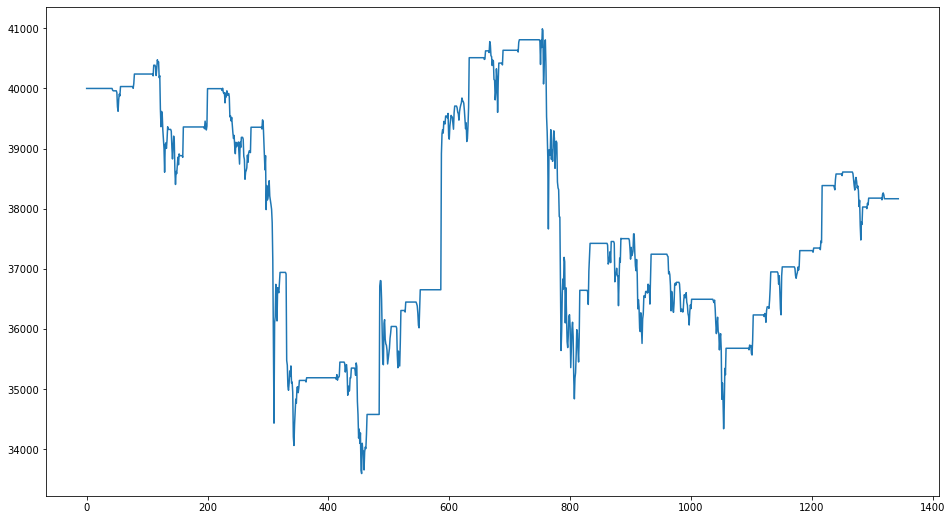

In [86]:
plt.plot(portfolio)

In [87]:
# win analytics
pctGain = (100/40000)*49601.53 - 100
perDay = pctGain / 14 # 14 days
pctPerDay = perDay / 100
pctPerDay

0.017145589285714292

In [88]:
startMoney = 40000
bank = []
for i in range(365*3):
    startMoney = startMoney * (1 + pctPerDay)
    bank.append(startMoney)
    if i % 30 == 0:
        if i > 0:
            monthnr = int(i / 30)
            perDayWin = bank[-1] - bank[-2]
            print("Month nr. %d, in bank: %s, per day win: %s"%(monthnr,"${:,.2f}".format(startMoney),"${:,.2f}".format(perDayWin)))

Month nr. 1, in bank: $67,754.28, per day win: $1,142.10
Month nr. 2, in bank: $112,831.49, per day win: $1,901.95
Month nr. 3, in bank: $187,898.77, per day win: $3,167.33
Month nr. 4, in bank: $312,908.62, per day win: $5,274.57
Month nr. 5, in bank: $521,088.08, per day win: $8,783.76
Month nr. 6, in bank: $867,770.22, per day win: $14,627.63
Month nr. 7, in bank: $1,445,101.49, per day win: $24,359.46
Month nr. 8, in bank: $2,406,533.74, per day win: $40,565.91
Month nr. 9, in bank: $4,007,610.99, per day win: $67,554.59
Month nr. 10, in bank: $6,673,891.85, per day win: $112,498.95
Month nr. 11, in bank: $11,114,060.85, per day win: $187,344.98
Month nr. 12, in bank: $18,508,293.40, per day win: $311,986.41
Month nr. 13, in bank: $30,821,940.71, per day win: $519,552.31
Month nr. 14, in bank: $51,327,910.62, per day win: $865,212.69
Month nr. 15, in bank: $85,476,590.64, per day win: $1,440,842.42
Month nr. 16, in bank: $142,344,534.56, per day win: $2,399,441.10
Month nr. 17, in 